In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

Text(0, 0.5, 'Test accuracy')

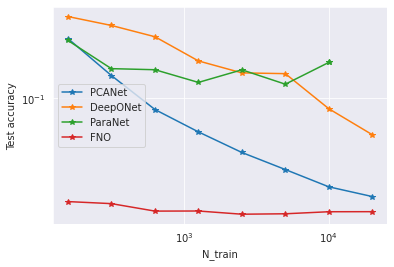

In [2]:
import pandas as pd

PCANet = pd.read_csv("data/PCA_Helmhotz.csv", header = None).to_numpy()
DeepONet = pd.read_csv("data/DeepONet_Helmhotz.csv", header = None).to_numpy()
Para = pd.read_csv("data/PARA_Helmhotz.csv", header = None).to_numpy()
FNO = pd.read_csv("data/FNO_Helmhotz.csv", header = None).to_numpy()

#The columns = [Nexamples, network width, Train, Test]

import seaborn as sns
sns.set_style('darkgrid')

#plt.plot(PCA[PCA[:,1] == 512][:,0], PCA[PCA[:,1] == 512][:, 3])
plt.plot(PCANet[PCANet[:,1] == 512][:,0], PCANet[PCANet[:,1] == 512][:, 4],'-*', label = 'PCANet')
plt.plot(DeepONet[DeepONet[:,1] == 512][:,0], DeepONet[DeepONet[:,1] == 512][:, 3],'-*', label = 'DeepONet')
plt.plot(Para[Para[:,1] == 512][:,0], Para[Para[:,1] == 512][:, 3],'-*', label = 'ParaNet')
plt.plot(FNO[FNO[:,1] == 32][:,0], FNO[FNO[:,1] == 32][:, 3],'-*', label = 'FNO')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N_train')
plt.ylabel('Test accuracy')

In [3]:
np.min(FNO[FNO[:,1] == 32][-1, 3]) #Relative test error to beat

0.0173936465122038

In [4]:
Inputs = np.load('data/Helmholtz_inputs.npy')
Outputs = np.load('data/Helmholtz_outputs.npy')

In [5]:
Inputs = Inputs.transpose((2,1,0))
Outputs = Outputs.transpose((2,1,0))

Inputs_fl = Inputs.reshape(len(Inputs), 101*101)
Outputs_fl = Outputs.reshape(len(Outputs), 101*101)

First baseline: Linear regression.
Results: 20000 128
0.1044466455094357 0.10592320122914789


In [6]:
# results = []
# for Ntrain in [20000]:
#     for N_components in [128]:
#         print(Ntrain, N_components)
#         Ytr = Outputs_fl[:Ntrain]
#         Xtr = Inputs_fl[:Ntrain]
#         pca = PCA(n_components=min(N_components,Ntrain))
#         Xtr = pca.fit_transform(Xtr)
#         reg = LinearRegression(n_jobs = -1).fit(Xtr, Ytr)
#         #Ypred Ypredtr = reg.predict(Xtr)
#         Ypredtr = reg.predict(Xtr)
#         train_error = np.mean(np.linalg.norm(Ypredtr-Ytr, axis = 1)/np.linalg.norm(Ytr, axis = 1))
#         Xtest = Inputs_fl[20000:]
#         Ytest = Outputs_fl[20000:]
#         Xtest = pca.transform(Xtest)
#         Ypred = reg.predict(Xtest)
#         test_error = np.mean(np.linalg.norm(Ypred-Ytest, axis = 1)/np.linalg.norm(Ytest, axis = 1))
#         print(train_error, test_error)
#         results.append([Ntrain, N_components, train_error, test_error])

# results = np.array(results)

GPR

There are 20000 training points, each of them is a 101x101 matrix that needs to be mapped to another 101x101 matrix. I can do (kernel?) PCA in the input and do each of the output GP regressions independently

In [8]:
from sklearn.metrics import pairwise_distances
import numpy as onp
import jax.numpy as np
from jax import jit, vmap
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as t
from ipywidgets import interact
from scipy.linalg import cho_solve
from jax import grad
from jax.scipy.optimize import minimize
from jax.config import config
config.update("jax_enable_x64", True)
import jax
from jax.scipy.linalg import cho_factor, cho_solve
from jax.scipy.optimize import minimize
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_box

In [9]:
#First, do PCA

In [10]:
# Inputs_fl.shape

# Xtr = Inputs_fl[:Ntrain]
# pca = PCA(n_components=0.99)
# Xtr = pca.fit_transform(Xtr)
# #Xtr = np.load('helmpca99.npy')

# Xte = pca.transform(Inputs_fl[Ntrain:])

# np.save('helmpca99Tr.npy', Xtr)
# np.save('helmpca99Te.npy', Xte)

In [11]:
#95% of the variance is 16 components (!)
#99% of the variance is 47 components, we will roll with that for now
#np.save('helmpca99.npy', Xtr)

In [12]:
Xtr = np.load('helmpca99Tr.npy')
Xte = np.load('helmpca99Te.npy')
Ytr= Outputs_fl[:20000]
Yte = Outputs_fl[20000:]

In [13]:
# #Does linear regression lose performance when considering only the PCA proj? A bit, but not much
# results = []
# for Ntrain in [20000]:
#         reg = LinearRegression(n_jobs = -1).fit(Xtr, Ytr)
#         #Ypred Ypredtr = reg.predict(Xtr)
#         Ypredtr = reg.predict(Xtr)
#         train_error = np.mean(np.linalg.norm(Ypredtr-Ytr, axis = 1)/np.linalg.norm(Ytr, axis = 1))
#         Ytest = Outputs_fl[20000:]
#         Ypred = reg.predict(Xte)
#         test_error = np.mean(np.linalg.norm(Ypred-Ytest, axis = 1)/np.linalg.norm(Ytest, axis = 1))
#         print(train_error, test_error)

Gaussian process regression

In [14]:
#Let's keep it to 2000 points for now for prototyping

In [15]:
Xtr = np.load('helmpca99Tr.npy')
Xte = np.load('helmpca99Te.npy')
Ytr= Outputs_fl[:20000]
Yte = Outputs_fl[20000:]
N = 2000
Xtr = Xtr[:N]
Xte = Xte[:N]
Ytr = Ytr[:N,23]
Yte = Yte[:N,23]

In [16]:
def sqeuclidean_distances(x: np.ndarray, y: np.ndarray) -> float:
    return np.sum( (x - y) ** 2)
dists = jit(vmap(vmap(sqeuclidean_distances, in_axes=(None, 0)), in_axes=(0, None)))

def euclidean_distances(x: np.ndarray, y: np.ndarray) -> float:
    return np.sqrt(np.sum( (x - y) ** 2))
sqdists = jit(vmap(vmap(euclidean_distances, in_axes=(None, 0)), in_axes=(0, None)))


@jit
def matern(v1, v2, sigma = 50):
    #V1 is a [k1] vector
    #V2 is a [k2] vector
    #returns a k1xk2 matrix
    d = sqdists(v1, v2)
    #return a*np.exp(-d**2/sigma)
    return (1+np.sqrt(5)*d/sigma +5*d**2/(3*sigma**2))*np.exp(-np.sqrt(5)*d/sigma)

@jit
def exp(v1, v2, sigma):
    #V1 is a [k1] vector
    #V2 is a [k2] vector
    #returns a k1xk2 matrix
    d = dists(v1, v2)
    return np.exp(-d/sigma)
    #return (1+np.sqrt(5)*d/sigma +5*d**2/(3*sigma**2))*np.exp(-np.sqrt(5)*d/sigma)


@jit
def k(v1, v2, sigma):
    #V1 is a [k1] vector
    #V2 is a [k2] vector
    #returns a k1xk2 matrix
    d = dists(v1, v2)
    #return a*np.exp(-d**2/sigma)
    #return (1+np.sqrt(5)*d/sigma +5*d**2/(3*sigma**2))*np.exp(-np.sqrt(5)*d/sigma)
    return 1/np.sqrt(d+sigma)

In [17]:
s = 200
nugget = 1e-8
Kxx = k(Xtr,Xtr, s)
nuggeted_matrix = Kxx+nugget*np.eye(len(Kxx))
Train_pred = Kxx@np.linalg.solve(nuggeted_matrix, Ytr) #train predictions

K_te_tr = k(Xte, Xtr,s)
Test_pred = K_te_tr@np.linalg.solve(nuggeted_matrix, Ytr) #test predictions


aux1 = np.mean(np.linalg.norm(Ytr-Train_pred))
aux2 = np.mean(np.linalg.norm(Train_pred-Ytr)/np.linalg.norm(Ytr))
aux3 = np.mean(np.linalg.norm(Yte-Test_pred))
aux4 = np.mean(np.linalg.norm(Yte-Test_pred)/np.linalg.norm(Yte))
print("\n Train error (abs): {0} \n Train error (rel): {1} \n Test error (abs): {2} \n Test error (rel): {3}".format(aux1, aux2, aux3, aux4))

In [57]:
np.linalg.norm(Lx-np.eye(len(Lx)))

DeviceArray(0.68860764, dtype=float64)

In [25]:
Lx = np.linalg.cholesky(exp(Xtr, Xtr, 5)+1e-8*np.eye(len(Xtr)))
Ly = np.linalg.cholesky(exp(Ytr, Ytr, 0.1)+1e-8*np.eye(len(Xtr)))

Xtrn = Lx.T@Xtr
Xten = Lx.T@Xte
Ytrn = Ytr
Yten = Yte

In [26]:
s = 200
nugget = 1e-8
Kxx = k(Xtrn,Xtrn, s)
nuggeted_matrix = Kxx+nugget*np.eye(len(Kxx))
Train_pred = Kxx@np.linalg.solve(nuggeted_matrix, Ytrn) #train predictions
K_te_tr = k(Xten, Xtrn,s)
Test_pred = K_te_tr@np.linalg.solve(nuggeted_matrix, Ytrn) #test predictions

aux1 = np.mean(np.linalg.norm(Ytrn-Train_pred))
aux2 = np.mean(np.linalg.norm(Train_pred-Ytrn)/np.linalg.norm(Ytrn))
aux3 = np.mean(np.linalg.norm(Yten-Test_pred))
aux4 = np.mean(np.linalg.norm(Yten-Test_pred)/np.linalg.norm(Yten))
print("\n Train error (abs): {0} \n Train error (rel): {1} \n Test error (abs): {2} \n Test error (rel): {3}".format(aux1, aux2, aux3, aux4))


 Train error (abs): 1.0627638914770924e-06 
 Train error (rel): 2.1186909005341836e-06 
 Test error (abs): 0.07178035292688127 
 Test error (rel): 0.14098873798670944


In [19]:
minus_log_lik(15)

DeviceArray(-398.19052375, dtype=float64)

In [18]:
@jit
def minus_log_lik(w, nugget = 1e-10):
    sigma = w
    #points, values are defined globally
    Kxx = k(Xtr, Xtr, sigma)
    cho = cho_factor(Kxx + nugget*np.eye(len(Kxx)))
    Kxxinvy = cho_solve(cho, Ytr)
    return 1/2 * np.dot(Ytr, Kxxinvy) + np.sum(np.log(np.diag(cho[0]))) + N*np.log(2*np.pi)/2

In [99]:
pg = ProjectedGradient(minus_log_lik, projection_box, stepsize=1)
result = pg.run(np.array([3.0]), hyperparams_proj=[1, 10])

In [88]:
conditional_mean.shape

(2000, 10201)

In [ ]:
Ypredtr = model.predict(Xtr)
train_error = np.mean(np.linalg.norm(Ypredtr-Ytr, axis = 1)/np.linalg.norm(Ytr, axis = 1))
Xtest = Inputs_fl[20000:]
Ytest = Outputs_fl[20000:, 0]
Xtest = pca.transform(Xtest)
Ypred= model.predict(Xtest)
test_error = np.mean(np.linalg.norm(Ypred-Ytest, axis = 1)/np.linalg.norm(Ytest, axis = 1))


In [36]:
Xtr

DeviceArray([[ -2.77115609,  -8.58676179,   8.72510747, ...,
               -0.11142542,   0.34297318,  -0.21757344],
             [-10.52210949,  -3.11213512,  -1.3363005 , ...,
                0.22869471,  -0.103262  ,  -0.2298788 ],
             [ -3.04186315,  -7.91624238,  -3.73750711, ...,
               -0.1110452 ,   0.05657988,   0.02523442],
             ...,
             [  1.56874584,  -3.42762138,   0.08303753, ...,
               -0.19135447,  -0.13691135,   0.20932283],
             [  0.4100681 ,  -3.00188211,  -8.04930931, ...,
                0.33842405,   0.37900876,   0.19135342],
             [  4.49437184,  -6.96614508,   7.46132592, ...,
                0.22172341,   0.0624004 ,   0.02216762]], dtype=float64)

In [217]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, RationalQuadratic

kernel = Matern() + RBF() + RationalQuadratic()

resultsgp = []
model = GaussianProcessRegressor(kernel, alpha = 1e-10)
model.fit(Xtr, Ytr)
Train_pred = model.predict(Xtr)
Test_pred = model.predict(Xte)
aux1 = np.mean(np.linalg.norm(Ytr-Train_pred))
aux2 = np.mean(np.linalg.norm(Train_pred-Ytr)/np.linalg.norm(Ytr))
aux3 = np.mean(np.linalg.norm(Yte-Test_pred))
aux4 = np.mean(np.linalg.norm(Yte-Test_pred)/np.linalg.norm(Yte))
print("\n Train error (abs): {0} \n Train error (rel): {1} \n Test error (abs): {2} \n Test error (rel): {3}".format(aux1, aux2, aux3, aux4))

/home/pau/anaconda3/envs/jax/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/pau/anaconda3/envs/jax/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/pau/anaconda3/envs/jax/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



 Train error (abs): 3.940204645103547e-06 
 Train error (rel): 7.855061500274305e-06 
 Test error (abs): 0.06288630665142021 
 Test error (rel): 0.12351932875644292


In [214]:
Lx = np.linalg.cholesky(k(Xtr, Xtr, 10)+1e-8*np.eye(len(Xtr)))
Ly = np.linalg.cholesky(k(Ytr, Ytr, 10)+1e-8*np.eye(len(Xtr)))

Xtrn = Lx.T@Xtr
Xten = Lx.T@Xte
Ytrn = Ly.T@Ytr
Yten = Ly.T@Yte

In [216]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, RationalQuadratic

kernel = Matern() + RBF() + RationalQuadratic()

resultsgp = []
model = GaussianProcessRegressor(kernel, alpha = 1e-10)
model.fit(Xtrn, Ytrn)
Train_pred = model.predict(Xtrn)
Test_pred = model.predict(Xten)
aux1 = np.mean(np.linalg.norm(Ytrn-Train_pred))
aux2 = np.mean(np.linalg.norm(Train_pred-Ytrn)/np.linalg.norm(Ytrn))
aux3 = np.mean(np.linalg.norm(Yten-Test_pred))
aux4 = np.mean(np.linalg.norm(Yten-Test_pred)/np.linalg.norm(Yten))
print("\n Train error (abs): {0} \n Train error (rel): {1} \n Test error (abs): {2} \n Test error (rel): {3}".format(aux1, aux2, aux3, aux4))

/home/pau/anaconda3/envs/jax/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



 Train error (abs): 4.169801619262345e-05 
 Train error (rel): 4.938201621010204e-06 
 Test error (abs): 8.769342449972111 
 Test error (rel): 1.000224506498347
